## Progetto Cerrito - Riconoscimento e classificazione delle cellule malate di malaria

Import delle librerie necessarie al funzionamento del codice:

In [52]:
import os
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as imgplt
from sklearn.model_selection import train_test_split
import ipywidgets as widgets
from PIL import Image
from keras.preprocessing.image import ImageDataGenerator, img_to_array
from keras.models import Sequential
from keras.models import load_model
from keras.layers import Conv2D, MaxPooling2D
from keras.layers import Flatten, Dense, Dropout
from keras import backend as K

# Parametri del modello

1. __train_data_dir__ ------------> Directory contenente il dataset di training del modello.
2. __img_width, img_height__ -----> Dimensioni delle immagini adattate all'uso nel modello (con eventuale ridimensionamento)
3. __nb_train_samples__ ----------> Dimensione dei campioni utilizzati nel training
4. __nb_validation_samples__ -----> Numero di campioni utilizzati durante il test del modello
5. __epochs__ --------------------> Numero di epochs utilizzate per il training del modello
6. __batch_size__ ----------------> Numero di campioni utilizzati per ogni singolo passo di training (weights adjustment)

In [53]:
out = widgets.Output(layout={'border': '1px solid black'})
out.append_stdout("Son")
train_data_dir = os.path.join('cell_images', 'Dataset')

print("Directory relativa del dataset: ", train_data_dir)

img_width, img_height = 64, 64
nb_train_samples = 3000
nb_validation_samples = 990
epochs = 50
batch_size = 16

Directory relativa del dataset:  cell_images/Dataset


# Modello della rete neurale

Si imposta la forma di input (shape) verificando l'eventuale dipendenza dal backend __image_data_format__, per uniformare la lettura delle immagini.

Si inizializza il modello inserendo __Sequential()__ così da poter utilizzare in maniera sequenziale più livelli ordinati dall'input all'output.
![Sequential Model](./doc_images/sequential_model.png)

In [55]:
if K.image_data_format() == 'channels_first':
    input_shape = (3, img_width, img_height)
else:
    input_shape = (img_width, img_height, 3)

model = Sequential()

## 1. Rete Convoluzionale
Si aggiunge un layer convoluzionale 2D, per analizzare le immagini in input. Osservando la figura sottostante, vi sono k funzioni kernels che vengono applicate all'immagine e producono un output 2D, detta mappa di attivazione. 

![Conv2D workflow.](./doc_images/conv2d.png "Conv2d")

Sarà necessario impostare più layer Conv2D affinchè la rete possa funzionare al meglio. 
Nel caso specifico si utilizzano 3 layer.

Primo layer: l'immagine considerata è una matrice A densa X,Y i cui valori sono vettori: $$v_{i,j} \in R^3$$
__v<sub>i,j</sub>__ rappresenta il pixel dell'immagine, tramite la rappresentazione rgb 

La matrice A è una matrice densa, tramite i vari livelli di convoluzione, la rete scompone e riduce le informazioni contenute in A, cercando di estrarre solo quelle necessarie. In particolare la Conv2D appplica k funzione kernels su porzioni dell'immagine, per produrre in output una mappa 2D. La mappa viene prodotta tramitte apprendimento di filtri. 
La complessità della matrice A comporta che al primo livello i filtri appressi sono in numero ridotto. L'uso di più livelli e funzioni Conv2D aumenta il numero di filtri appresi, anche se nel contempo, le informazioni in input vengono ridotte.

Per un corretto funzionamento della network si impostino i seguenti parametri:

1. Numero di canali in output della Conv2D (nel primo layer a 32)
2. __kernel_size__ (cioè una finestra di dimensioni 3x3 che si muove sull'immagine)
3. __strides__ (passi) nelle direzioni x e y (1, 1).
4. __activation__ funzione di attivazione a "relu: rectified linear unit" 
5. __input_shape__ precedentemente calcolata (necessaria solo per il primo livello)

L'apprendimento tramite Conv2D avviene a fasi: 
1. analizza l'immagine da sinistra verso destra e dall'alto verso il basso. Alla posizione corrente, applica i filtri e calcola la mappa
2. verifica che non ha raggiunto il bordo a destra dell'immagine, nel caso si sposta in basso di Y pixel (secondo valore di strides) e al bordo sinistro. Se non è sul bordo destro,  si sposta in avanti di x passi (primo valore di strides) e applica ancora i filtri
4. ripete i passi 1 e 2 finchè non copre l'intera immagine e termina


In [56]:
model.add(Conv2D(32, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu',
                 input_shape=input_shape))

### 1.1 Funzione di attivazione
keras permette di utilizzare diverse funzioni di attivazione della convoluzione:

![Activation Function](./doc_images/activation_function.png)

In particolare la funzione relu, con i parametri di default è definita come (come riportato nella documentazione di Keras):

$$relu(x)=max(x,0)$$

Altrimenti segue:

$$relu(x) =\begin{cases} maxvalue  & x \ge maxvalue \\ 
x & threshold \le x < maxvalue \\
x - threshold & altrimenti
\end{cases}$$


### 1.2 Riduzione dei valori di output di Conv2D

Per ridurre le dimensioni spaziali dell'output della convoluzione 2D, si applica la funzione __MaxPooling2D()__

In particolare con i parametri:
1. il numero di input atteso
2. __pool_size__ la dimensione del pool
3. __strides__ i passi in avanti nelle direzioni x ed y

In [32]:
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

Come indicato in precendenza aggiungiamo i layer successivi alla deep network:

In [33]:
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

## 2. Dense layer (connessione completa)

Per poter porcede alla classificazione delle immagini, dobbiamo valutare i dati in output della sottorete di convoluzione. Il modo migliore per farlo è pesare i dati ottenuti tramite l'uso di una sottorete fully connected. La __Dense()__ è rete neurale di n neuroni completamente connessi, la cui funzione è calcorare i pesi associati ai dati in input.

I parametri impostati:
1. il numero di valori in input attesi
2. __activation__ la funzione di attivazione

Il primo strato pesa i valori utilizzando la funzione relu, come definita in precendeza, in maniera da essere coerente con la rete di convoluzione. Il secondo strato, partendo dai pesi precedenti, esegue effettivamente la classificazione, nel caso specifico la classificazioni binaria, tramite la funzione di attivazione sigmoid: 

$$sigmoid(x) ={1 \over 1+e^{-x}}= {e^x \over 1 + e^x}$$

Interposta tra i due livelli Dense vi è la funzione __Dropout__, che imposta casualmente una percentuale di valori in input a 0 durante la valutazione, per prevenire ulteriormente l'overfitting.

La funzione __Flatten()__ partendo da un tensore multidimensionale, produce in output un tensore mono dimensionale. Il suo utilizzo è necessario per poter generare l'input della sottorete fully connected.

In [35]:
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

I passi fatti fino ad ora, hanno permesso di definire il modello della deep network. Dal modello, si genera la rete tramite la funzione __model.compile()__

i parametri utilizzati per generare la network:
1. La funzione di loss (perdita) da minimizzare
2. La funzione di ottimizzazione, utilizzata nel processo di apprendimento
3. La metrica utilizzata per valutare il modello generato

La classificazione che il modello prevede è una clssificazione binaria. Definendo le classi attese come: $$y \in {(0,1)}$$ la funzione di loss associata:
$$H_p(q)=-{1 \over N}\sum\limits_{i=1}^{N}y_i \log(p(y_i))+ (1-y_i) \log((1-p(y_i))$$

e p(y) è la probabilità che y appartenga alla classe 1, viceversa 1-p(y) che appartenga alla classe 0.

Analizzando la formula, si nota che per ogni punto y = 1, aggiunge il valore log(p(y)) alla funzione loss, la log probabilità di appartenere alla classe 1. viceversa, aggiunge log(1-p(y)), la log porbabilità di appartenere alla classe 0.

Poichè si sta valutando una funzione di perdita, si vuole penalizzare le predizioni errate. Se la probabilità associata è 1.0 e la classe è giusta, la loss deve essere 0, se la probabilità associata risulta essere vicino allo zero ma la classe è quella esatta, cioè abbiamo una predizione errata, la funzione loss deve essere elevata.
L'uso della funzione log, visto che il log dei valori compresi tra 0 ed 1 è negativo, prendendo il -log nella funzione, otteniamo valori positivi per la funzione loss. 

#### Entropia
L'entropia è la misura dell'incertezza associata ad una distribuzione data q(y). Per capire, se i punti dati appartenessero tutti ad una sola classe, esempio verde, l'entropia risulta essere 0, visto che predire il colore equivale ad essere certi che il colore sia giusto, coiè verde. viceversa, nel caso peggiore in cui i punti sono metà del colore verde e metà del colore rosso, non vi è nessuna possibilà di poter predire il colore, in tal caso l'entropia (l'incertezza di cosa uscirà) è massima.
L'entropia per la classificazione su C classi:
$$H(q)=-\sum\limits_{i=1}^{C}q(y_i) \log (q(y_i))$$

Per cui, conoscendo la vera distribuzione di una variabile, possiamo calcolare la sua entropia.

#### Cross Entropia
Si supponga che i punti siano approssiamti da una distribuzione nota p(y), ma che la loro vera distribuzione si q(y) e sia sconosciuta. Se calcoliamo l'entropia, cioè la cross entropia tra le due distribuzioni:
$$H_p(q)=-\sum\limits_{i=1}^{C}q(y_i) \log(p(y_i))$$

Se la distribuzione p(y) è uguale a q(y) per ogni valore, allora la cross entropia così calcolata è uguale all'entropia. Ma ne caso reale, la cross entropia assume un valore più grande dell'entropia:
$$H_p(q) - H(q) > 0$$

#### rmprop
Per spiegare rmprop si intorduce il concetto di discesa del gradiente e la variante discesa col gradiente con momento.

La discesa dei gradienti è uno degli ottimizzatori più utilizzato, è un metodo semplice ed efficace per trovare i valori ottimali per la rete neurale. L'obiettivo di tutti gli ottimizzatori è di raggiungere i minimi globali laddove la funzione di costo raggiunge il minor valore possibile. Un esempio:

![gradiente](./doc_images/grad1.jpg)

L'algoritmo, ad ogni passo:
1. calcola il valore predetto dalla rete neuarale
2. calcola ilv alore della funzione di loss
3. calcola il gradiente tramite le derivate parziali della funzione di loss
4. usa i gradienti calcolati per aggiornare i pesi ed il bias

Come dalla figuar si parte dal punto A, dove il vaolre della funzione costo è elevato. Man mano che si applica l'algoritmo, cioè viene fatto il training della rete neurale, viene ridotto la funzione costo e tende verso il minimo B. Nella figura sottostante si vede una simulazione di training:

![gradiente simulazione](./doc_images/grad2.gif)

L'algoritmo così come definito funzione correttamente sulle funzioni convesse, ma spesso le funzioni considerate non lo sono, si consideri ad esempio:

![funzione non convessa](./doc_images/grad3.png)

La funzione presenta massimi e minimi locali. La discesa del gradiente, se si trova vicino un minimo locale, può convergere ad esso e non andare verso invece il minimo globale, presentando risultati errati. Esistono algoritmi che permettono di ridurre il problema dei minimi locali.

Osserviamo l'immagine:

![momentum example](./doc_images/mom1.png)

L'algoritmo standard si muove in entrambe le direzioni x ed y in equal misura, ma se l'algortimo fosse in grado di ridurre i passi nella direzione y e si concentrasse sulla direzione x, convergerebbe alla soluzione molto più rapidamente.
l'introduzione del momento, limita l'oscillazione in una direzione in modo che l'algoritmo possa convergere più velocemente. A maggior vantaggio, visto che i passi eseguiti nella direzione y sono limitati, è possibile impostare un tasso di apprendimento più elevato. Le equazioni del calcolo dei gradienti da parte dell'algoritmo con quantità di moto, dove beta è il momento e di norma viene posto a 0.9:

$$v_{dw}=\beta v_{dw} + (1-\beta)dw$$
$$v_{db}=\beta v_{dw} + (1-\beta)db$$
$$W = W - \alpha v_{dw}$$
$$b = b - \alpha v_{db}$$

Ora, dopo aver introdotto la discesa del gradiente e il momento, si può descrivere correttamente l'ottimizzatore rmprop.
RMSprop è molto simile all'algoritmo di discesa del gradiente con momento, infatti limita le oscillazioni nella direzione verticale. Pertanto, si può aumentare il tasso di apprendimento ed ingrandire i passi  nella direzione orizzontale, convergendo più velocemente. La differenza tra RMSprop e discesa del gradiente è nel modo in cui sono calcolati i gradienti. le equazioni:

$$v_{dw}=\beta v_{dw} + (1-\beta)d{w^2}$$
$$v_{db}=\beta v_{dw} + (1-\beta)d{b^2}$$
$$ W = {W - \alpha {dw \over \sqrt {v_{dw}}+ \epsilon}}$$
$$b = {b - \alpha {db \over \sqrt{v_{db}} + \epsilon}}$$

Il parametro epsilon viene introdotto per evitare che se v<sub>dw</sub> è vicino allo zero, il gradiente possa esplodere.

#### metrics
viene impostata alla metrica di default __categorical_accuracy__, che calcola il tasso medio di accuratezza in tutte le previsioni per i problemi di classificazione multiclasse.

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer='rmsprop',
              metrics=['accuracy'])

## Preparazione dei dati per la rete


Per convenzione si assegnato le seguenti label, a partire dalla directory di input:
1. unifected = 0
2. parasitized = 1

non avendo a disposizione due dataset per fare training e verifica, si divide il dataset in tre parti:
1. training set (training)
2. test set (training)
3. validation (prediction time)

Si procede dividendo il dataset al 20% dedicato al dataset di test, utilizzato durante il training nella fase di test. Il rimante dataset viene ulteriormente suddivio al 50% tra training e validation. 

In [37]:
data = []
uninfected = os.listdir(train_data_dir+"/Uninfected")
parasitized = os.listdir(train_data_dir+"/Parasitized")

for i in uninfected:
    data.append([train_data_dir+"/Uninfected/"+i,'Uninfected'])
for i in parasitized:
    data.append([train_data_dir+"/Parasitized/"+i,'Parasitized'])
random.shuffle(data)
image = [i[0] for i in data]
label = [i[1] for i in data]
del data

X_train, X_test, Y_train, Y_test = train_test_split(image, label, test_size=0.2, random_state=42)
X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=0.5, random_state=46)


Keras permette di utilizzare la classe __ImageDataGenerator()__ per generare un nuovo dataflow a partire da una directory su filesystem per generare l'input del nostro modello di training. 

Si applicheranno nel seguito anche le funzioni di trasformazioni delle immagini, affinchè il modello non veda due volte di seguito la stessa immagine ed eseguire il training più accurato, evitando (o almeno riducendo drasticamente) il problema dell'overfitting. Inoltre il modello risultante sarà più generalizzato.

I parametri impostati sono:

* __rotation_range__ valore in gradi compreso tra 0 e 180°, con il quale il modello ruoterà randomicamente le immagini.
* __width_shift__ e __height_shift__ intervalli dati come frazioni delle dimensioni totali di cui il modello transla orizzontalmente e verticalmente le immagini randomicamente.
* __rescale__  è un valore con cui saranno riscalati i dati in input prima di qualsiasi altro processo. Le immagini originali consistono in coefficienti RGB dati come valori tra 0 e 255, ma tali valori sono troppo alti per il modello, si riscalano a valori compresi tra 0 e 1 .
* __shear_range__ percentuale di applicazione di funzioni di taglio randomiche
* __zoom_range__ percentuale di applicazione di funzioni di zoom randomiche.
* __horizontal_flip__  per capovolgere metà delle immagini orizzontalmente, vale a dire quando non ci sono assunzioni di asimmetria orizzontale (ad esempio nel caso di immagini reali)
* __fill_mode__ è la funzione utilizzata per generare i pixel che potrebbero essere creati dalla funzione di rotazione o dalla translazione.

In [38]:
train_datagen = ImageDataGenerator(
        rotation_range=40,
        width_shift_range=0.2,
        height_shift_range=0.2,
        rescale=1./255,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest')

## Caricamento immagini da una directory (e relative sottodirectory)

Si generano i dataframe a partire dai dataset generati in precendenza, tabelle che associano il filename alla label. Si ricorda che  X_name sono i nome dei file dele immagini, Y_name le label associate, per tutti i dataset considerati.

In [39]:
x_train_dataframe = pd.DataFrame({'Filename':X_train, 'Label':Y_train})
x_testval_dataframe = pd.DataFrame({'Filename':X_test, 'Label':Y_test})
x_validation_dataframe = pd.DataFrame({'Filename':X_val, 'Label':Y_val})

x_train_dataframe.head(4)

,Filename,Label
0,cell_images/Dataset/Uninfected/C37BP2_thinF_IM...,Uninfected
1,cell_images/Dataset/Parasitized/C132P93ThinF_I...,Parasitized
2,cell_images/Dataset/Uninfected/C77P38ThinF_IMG...,Uninfected
3,cell_images/Dataset/Uninfected/C56P17thinF_IMG...,Uninfected


## Training e test generator

Keras tra le varie funzioni, mette a disposizione __flow_from_dataframe__, che carica le immagini applicando anche delle trasformazioni a partire dai dataframe generati in precedenza, nel caso specifico indicando la batch_size e le dimensioni a cui riscalare le immagini.

Si pone inoltre il parametro __directory__ a None, visto che nell'X_train e nel X_test sono già specificati i percorsi delle immagini.

In [40]:
X_train_generator = train_datagen.flow_from_dataframe(dataframe = x_train_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))
X_testval_generator = train_datagen.flow_from_dataframe(dataframe = x_testval_dataframe,directory = None, x_col = 'Filename', y_col = 'Label', class_mode = 'binary', batch_size = batch_size, target_size=(img_width, img_height))

Found 11023 validated image filenames belonging to 2 classes.
Found 5512 validated image filenames belonging to 2 classes.


# Modello Generato

Si può riassumere il modello generato dalle impostazioni precedenti con la funzione __summary__:

In [41]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_4 (Conv2D)            (None, 62, 62, 32)        896       
_________________________________________________________________
max_pooling2d_4 (MaxPooling2 (None, 31, 31, 32)        0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 29, 29, 32)        9248      
_________________________________________________________________
max_pooling2d_5 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 12, 12, 64)        18496     
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 6, 6, 64)          0         
_________________________________________________________________
flatten_2 (Flatten)          (None, 2304)              0         
__________

## Training del modello

Si verifica l'esistenza dei file __malaria_weights.h5__, __malaria_model_trained__ e __validation_dataframe.csv__, nel qual caso vengono caricati, assumendo che il training della network sia già stato fatto in precendenza, altrimenti si procede al training della rete.

Essendo stati utilizzati i generator di keras, il training sarà fatto tramite la funzione __fit_generator__, con i parametri:

1. Il training dataset
2. __step_per_epoch__ i passi necessari per ogni epoch, calcolato come il numero di campioni di training diviso la dimensione di batch.
3. __epochs__ il numero di epoch con cui si farà il training del modello.
4. __validation_data__ il dataset di test per validare il modello.
5. __validation_steps__ i passi necessari per ogni epoch per la validazione, calcolato come il numero di campioni di test diviso la dimensione di batch.


In [43]:
savemod = 1
if os.path.exists('saved_model/malaria_weights.h5') and os.path.exists('saved_model/malaria_model_trained.mod') and os.path.exists('saved_model/validation_dataframe.csv'):
    history = load_model('saved_model/malaria_model_trained.mod')
    history.load_weights('saved_model/malaria_weights.h5')
    x_validation_dataframe = pd.read_csv('saved_model/validation_dataframe.csv')
    savemod = 0

else:
    history = model.fit_generator(
        X_train_generator,
        steps_per_epoch=nb_train_samples // batch_size,
        epochs=epochs,
        validation_data=X_testval_generator,
        validation_steps=nb_validation_samples // batch_size)

Epoch 1/50
187/187 [==============================] - 55s 295ms/step - loss: 0.7020 - acc: 0.5060 - val_loss: 0.6948 - val_acc: 0.4928
Epoch 2/50
187/187 [==============================] - 52s 277ms/step - loss: 0.6506 - acc: 0.6464 - val_loss: 0.5851 - val_acc: 0.6814
Epoch 3/50
187/187 [==============================] - 51s 275ms/step - loss: 0.4659 - acc: 0.8025 - val_loss: 0.3529 - val_acc: 0.8627
Epoch 4/50
187/187 [==============================] - 51s 272ms/step - loss: 0.3397 - acc: 0.8639 - val_loss: 0.3651 - val_acc: 0.8402
Epoch 5/50
187/187 [==============================] - 51s 270ms/step - loss: 0.3290 - acc: 0.8783 - val_loss: 0.2977 - val_acc: 0.9068
Epoch 6/50
187/187 [==============================] - 50s 270ms/step - loss: 0.3062 - acc: 0.8937 - val_loss: 0.3179 - val_acc: 0.8781
Epoch 7/50
187/187 [==============================] - 51s 272ms/step - loss: 0.3013 - acc: 0.8964 - val_loss: 0.2638 - val_acc: 0.9160
Epoch 8/50
187/187 [==============================] - 5

# Validità del modello
## 1. Informazioni loss e accuracy
Si può valutare il funzionamento del modello e come è stato eseguito il training, tramite __evaluate_generator__, utilizzando il dataset di test (Validation), mostrando i valori di loss e accuracy:

In [44]:
step_size_testval = X_testval_generator.n // batch_size
score=model.evaluate_generator(generator=X_testval_generator,steps=step_size_testval, verbose=0)
print('Loss sul dataset di test:', score[0])
print('Accuracy sul dataset di test:', score[1])


Loss sul dataset di test: 0.280184844348802
Accuracy sul dataset di test: 0.9215793304221251


## 2. Plot del grafico
Con il salvataggio del processo di training, si ha la possibilità di stampare le metriche e rappresentarle tramite un grafico. 
Osservando il grafico, si nota già che circa dopo solo 10 epochs, il modello sale  a circa il 90% di accuracy sul dataset di training e su quello di testing. Si potrebbe obiettare che sul dataset di test l'accuracy non è delle migliori, si attesta intorno al 50%, volutamente si mantiene il modello in queste circostanze, per evitare di avere overfitting sui dati. 

Cambiando alcuni parametri del modello, tra le varie impostazioni aumentare l'input del secondo layer convoluzionale, da 32 a 64 e del terzo layer da 64 a 128, aumentare anche la dimensione delle immagini, aumentare anche il numero di epochs, il modello migliorerebbe sensibilmente, pena l'aumento esponenziale del tempo di training della rete. Visto l'hardware a disposizione poco adatto ad eseguire processi di Machine Learning pesanti, si accetta il compromesso scelto, che comunque da ottimi risultati.

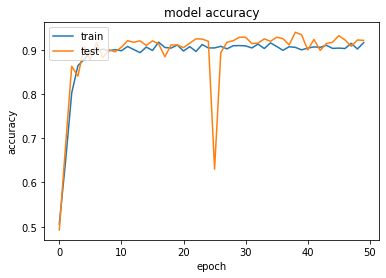

In [45]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## Salvataggio del modello

Per salvare il modello dopo l'apprendimento, si devono salvare:

1. I pesi risultanti del modello (weights). Non viene salvata l'architettura. (Può essere utile se si vuole spostare il modello su un diverso framework)
2. Si salva l'intera archietettura del modello, permettendo a keras di poterlo utilizzare
3. Si salva __x_validation_dataframe__ su csv, utile qualora si rifaccia una predict e si vuole avere a disposizione delle immagini che non sono state utilizzate per il training del modello. Si ricorda che i dataset sono suddivisi in maniera casuale.


In [46]:
if savemod:
    model.save_weights('saved_model/malaria_weights.h5')
    model.save('saved_model/malaria_model_trained.mod')
    x_validation_dataframe.to_csv('saved_model/validation_dataframe.csv')

# Fit sul validation dataset

Il modello è pronto a fare anche le previsioni. Avendo generato un dataset di validazione, viene utilizzato per fare fit (prediction). 

Si stampa il grafico dei risultati, si può verifica se ci sono state degli errori di previsione. Nel validation dataset sono presenti le etichette associate alle immagini (Uninfected, Parasized), si calcola quanti falsi positivi (cellule uninfected riconosciute come malate, caso meno grave) e quanti falsi negativi (cellule malate riconosciute come non infette; caso più grave). 

Il numero elevato di immagini da analizzare può essere ridotto alle prime 1000,  decommentando la __if.....break__.

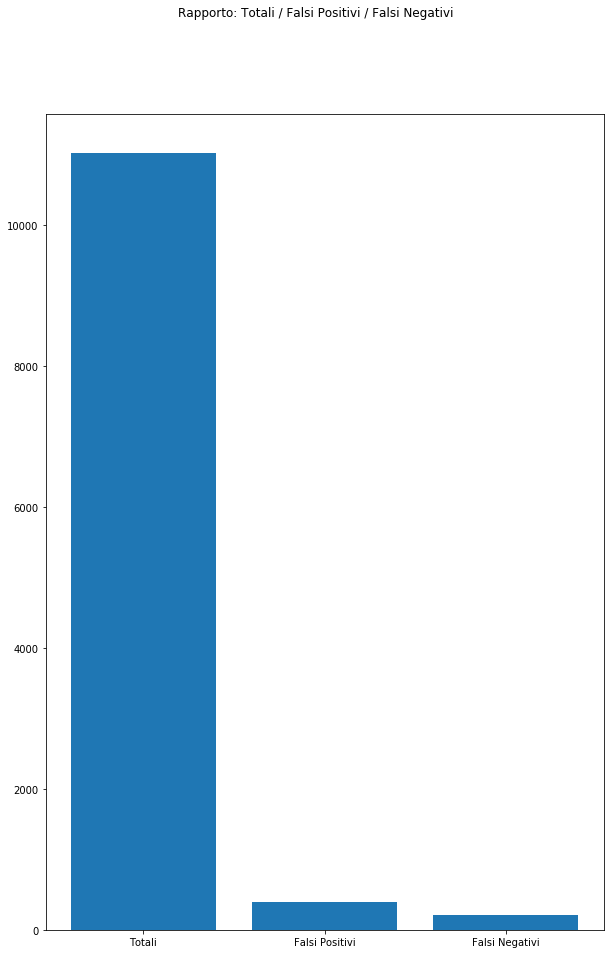

In [49]:
count=0
false_negative = 0
false_positive = 0

if savemod:
    for row in x_validation_dataframe.itertuples(index=True, name='Pandas'):
        img = Image.open(getattr(row, "Filename"))
        label = getattr(row, "Label")
        img = img.convert("RGB")
        img = img.resize((img_width, img_height), Image.ANTIALIAS)
        img = img_to_array(img)
        img = img/255.0
        img = img.reshape((1,) + img.shape)
        pred = model.predict(img)
        pred = pred.item(0)
        pred = np.round(pred, decimals = 3)
        if pred > 0.500 and label == 'Parasitized':
            false_negative = false_negative + 1
        if pred <= 0.500 and label == 'Uninfected':
            false_positive = false_positive + 1
        count=count + 1
        #if count >1000:
        #    break;               
    data = {'Totali' : count, 'Falsi Positivi' : false_positive, 'Falsi Negativi' : false_negative}
    dataf = pd.DataFrame.from_dict(data, orient="index")
    dataf.to_csv('saved_model/predicted_data.csv')
else:
    dataf = pd.read_csv('saved_model/predicted_data.csv', index_col=0)
    data = dataf.to_dict("split")
    data = dict(zip(d["index"], d["data"]))

    
names = list(data.keys())
values = list(data.values())

fig, axs = plt.subplots(1, 1, figsize=(10, 15), sharey=True)
axs.bar(names, values)
fig.suptitle('Rapporto: Totali / Falsi Positivi / Falsi Negativi')
plt.show()

